In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
path='/content/drive/MyDrive/Team8/task3/'

Mounted at /content/drive/


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os, numpy as np
from sklearn.utils import shuffle
from numpy import random

In [ ]:
seed = 32
torch.manual_seed(seed)

In [ ]:
os.listdir(path)

['testing_data_set_8.csv',
 'training_data_set_8_labeled.csv',
 'training_data_set_8_unlabeled.csv',
 'validation_data_set_8.csv']

In [ ]:
X_train_lab=pd.read_csv(path+'training_data_set_8_labeled.csv',header = None)
X_train_unlab=pd.read_csv(path+'training_data_set_8_unlabeled.csv',header = None)
X_test_lab=pd.read_csv(path+'testing_data_set_8.csv',header = None)
X_valid_lab=pd.read_csv(path+'validation_data_set_8.csv',header = None)

In [ ]:
X_train_lab.shape, X_train_unlab.shape, X_test_lab.shape, X_valid_lab.shape

((750, 37), (1750, 36), (250, 37), (250, 37))

In [ ]:
X_test=X_test_lab.iloc[:, :-1]
y_test=X_test_lab.iloc[:, -1]
X_valid=X_valid_lab.iloc[:, :-1]
y_valid=X_valid_lab.iloc[:, -1]

In [ ]:
shuffled_data = shuffle(X_train_lab)
shuffled_data.reset_index(drop=True, inplace=True)
X_train=shuffled_data.iloc[:, :-1]
y_train=shuffled_data.iloc[:, -1]

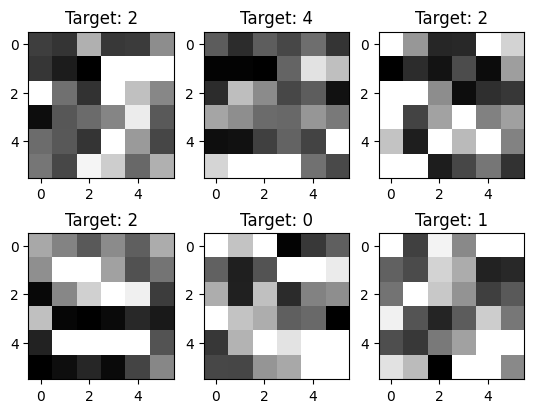

In [ ]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(np.array(X_train.iloc[i]).reshape(6,6), cmap='gray')
  plt.title(f'Target: {int(y_train.iloc[i])}')
  # plt.axis('off')

In [ ]:
class AANN(nn.Module):

  def __init__(self, input_size, hl1_size, hl2_size):
    super(AANN, self).__init__()
    self.hl1 = nn.Linear(input_size, hl1_size)
    self.hl2 = nn.Linear(hl1_size, hl2_size)
    self.hl3 = nn.Linear(hl2_size, hl1_size)
    self.ol=nn.Linear(hl1_size, input_size)

  def forward(self, x):
    x = self.hl1(x)
    x = F.tanh(x)
    x = self.hl2(x)
    x = self.hl3(x)
    x = F.tanh(x)
    x = self.ol(x)
    return x

  def bottle_neck(self, x):
    x = self.hl1(x)
    x = F.tanh(x)
    x = self.hl2(x)
    return x

In [ ]:
class StackedAutoencoder(nn.Module):

  def __init__(self, ae1, ae2, ae3):
    super(StackedAutoencoder, self).__init__()
    self.ae1 = ae1
    self.ae2 = ae2
    self.ae3 = ae3
    self.ol = nn.Linear(8, 5)

  def forward(self, x):
    x = self.ae1.bottle_neck(x)
    x = self.ae2.bottle_neck(x)
    x = self.ae3.bottle_neck(x)
    return self.ol(x).reshape(-1, 5)

In [ ]:
class DFNN(nn.Module):
  def __init__(self):
    super(DFNN, self).__init__()
    self.hl1 = nn.Linear(36, 30)
    self.hl2 = nn.Linear(30, 24)
    self.hl3 = nn.Linear(24, 20)
    self.hl4 = nn.Linear(20, 16)
    self.hl5 = nn.Linear(16, 12)
    self.hl6 = nn.Linear(12, 8)
    self.ol = nn.Linear(8, 5)

  def forward(self, x):
    x = self.hl1(x)
    x = F.tanh(x)
    x = self.hl2(x)
    x = self.hl3(x)
    x = F.tanh(x)
    x = self.hl4(x)
    x = self.hl5(x)
    x = F.tanh(x)
    x = self.hl6(x)
    return self.ol(x).reshape(-1, 5)

In [ ]:
def conf_matrix(model, X, y):
  with torch.no_grad():
    y_pred=[]
    y_true=[]
    for i in range(len(X)):
      X_tensor=torch.tensor(X.iloc[i], dtype=torch.float32)#, device='cuda')
      y_tensor=torch.tensor(y.iloc[i], dtype=torch.float32)#, device='cuda')
      y_hat=model(X_tensor)
      y_l=y_hat.tolist()[0]
      pred=y_l.index(max(y_l))
      y_pred.append(pred)
      y_true.append(y_tensor.item())
    cf = confusion_matrix(y_true, y_pred)
    print('Accuracy:', [y_true[i]-y_pred[i] for i in range(len(y_pred))].count(0)/len(y_pred), '%')
  return cf

In [ ]:
def train(model, train_loader, loss_func, validation_data=None):

  model.train()
  delta_avg_loss=2*threshold
  epoch=1
  avg_error_dict = {}
  prev_epoch_loss=float('inf')
  validation_loss = {}
  optimizer=optim.Adam(model.parameters(), lr=learning_rate)

  if validation_data:
    X_valid, y_valid = validation_data

  while abs(delta_avg_loss)>threshold:
    epoch_loss=0
    for batch_idx, (X, y) in enumerate(train_loader):
      y_hat=model(X)
      loss=loss_func(y_hat, y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      with torch.no_grad():
        epoch_loss+=loss.item()
        print(f'EPOCH: {epoch} BATCH: {batch_idx} LOSS: {loss.item()}')

    avg_epoch_loss = epoch_loss/len(train_loader)

    if validation_data:
      # Validation
      with torch.no_grad():
        y_hat_valid = model(X_valid)
        valid_loss = loss_func(y_hat_valid, y_valid)
        validation_loss.update({epoch:valid_loss})

    print('\n'+'-'*100+'\n')
    print(f'Total Loss: {epoch_loss}, Average Training Loss: {avg_epoch_loss}')
    if validation_data:
      print(f'Average Validation Loss: {valid_loss}')
    print('\n'+'-'*100+'\n')

    delta_avg_loss = prev_epoch_loss-avg_epoch_loss
    prev_epoch_loss = avg_epoch_loss
    avg_error_dict.update({epoch:avg_epoch_loss})
    epoch+=1

  return avg_error_dict, validation_loss if validation_data else avg_error_dict

## (a) DFNN trained with labelled data only

In [ ]:
learning_rate = 0.01
threshold = 1e-3

In [ ]:
X_train_tensor = torch.from_numpy(X_train.values).float()
y_train_tensor = torch.from_numpy(y_train.values).long()
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
                                            batch_size=32, shuffle=True)
X_valid_tensor = torch.from_numpy(X_valid.values).float()
y_valid_tensor = torch.from_numpy(y_valid.values).long()

In [ ]:

# random.seed(seed)
# weights_layer1 = random.normal(loc=0, scale=1/(36**0.5), size=(30, 36))
# weights_layer2 = random.normal(loc=0, scale=1/(30**0.5), size=(24, 30))
# weights_layer3 = random.normal(loc=0, scale=1/(24**0.5), size=(20, 24))
# weights_layer4 = random.normal(loc=0, scale=1/(20**0.5), size=(16, 20))
# weights_layer5 = random.normal(loc=0, scale=1/(16**0.5), size=(12, 16))
# weights_layer6 = random.normal(loc=0, scale=1/(12**0.5), size=(8, 12))
# weights_layer7 = random.normal(loc=0, scale=1/(8**0.5), size=(5, 8))

# weights_dict = {36:weights_layer1, 30:weights_layer2, 24:weights_layer3, 20:weights_layer4,
#                 16:weights_layer5, 12:weights_layer6, 8:weights_layer7}

In [ ]:
# def weights_init_normal(m):
#   classname = m.__class__.__name__
#   if classname.find('Linear') != -1:  # Only for linear layers
#     y = m.in_features
#     m.weight.data = torch.tensor(weights_dict[y], dtype=torch.float32)
#     m.bias.data.fill_(torch.tensor(0, dtype=torch.float32))

In [ ]:
model = DFNN()

In [ ]:
for layer in model.children():
  print(layer)

Linear(in_features=36, out_features=30, bias=True)
Linear(in_features=30, out_features=24, bias=True)
Linear(in_features=24, out_features=20, bias=True)
Linear(in_features=20, out_features=16, bias=True)
Linear(in_features=16, out_features=12, bias=True)
Linear(in_features=12, out_features=8, bias=True)
Linear(in_features=8, out_features=5, bias=True)


In [ ]:
# model = DFNN()
model.to(torch.float32)
# model.apply(weights_init_normal)
loss_func = nn.CrossEntropyLoss()
avg_error_dict, validation_loss = train(model, train_loader, loss_func, (X_valid_tensor, y_valid_tensor))

EPOCH: 1 BATCH: 0 LOSS: 1.6436660289764404
EPOCH: 1 BATCH: 1 LOSS: 1.575135588645935
EPOCH: 1 BATCH: 2 LOSS: 1.6069681644439697
EPOCH: 1 BATCH: 3 LOSS: 1.6670275926589966
EPOCH: 1 BATCH: 4 LOSS: 1.6480501890182495
EPOCH: 1 BATCH: 5 LOSS: 1.6231539249420166
EPOCH: 1 BATCH: 6 LOSS: 1.59504234790802
EPOCH: 1 BATCH: 7 LOSS: 1.518436074256897
EPOCH: 1 BATCH: 8 LOSS: 1.544220209121704
EPOCH: 1 BATCH: 9 LOSS: 1.3405523300170898
EPOCH: 1 BATCH: 10 LOSS: 1.4757286310195923
EPOCH: 1 BATCH: 11 LOSS: 1.401620864868164
EPOCH: 1 BATCH: 12 LOSS: 1.4156520366668701
EPOCH: 1 BATCH: 13 LOSS: 1.3920353651046753
EPOCH: 1 BATCH: 14 LOSS: 1.3738726377487183
EPOCH: 1 BATCH: 15 LOSS: 1.1859685182571411
EPOCH: 1 BATCH: 16 LOSS: 1.3152148723602295
EPOCH: 1 BATCH: 17 LOSS: 1.2989673614501953
EPOCH: 1 BATCH: 18 LOSS: 1.3486394882202148
EPOCH: 1 BATCH: 19 LOSS: 1.3129403591156006
EPOCH: 1 BATCH: 20 LOSS: 1.3344284296035767
EPOCH: 1 BATCH: 21 LOSS: 1.1248040199279785
EPOCH: 1 BATCH: 22 LOSS: 1.2932069301605225
EPOC

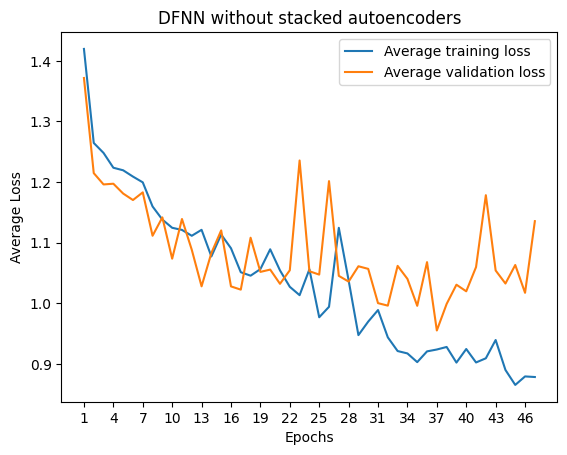

In [ ]:
plt.plot(list(map(str, list(avg_error_dict.keys()))), list(avg_error_dict.values()), label='Average training loss')
plt.plot(list(map(str, list(validation_loss.keys()))), list(validation_loss.values()), label='Average validation loss')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('DFNN without stacked autoencoders')
plt.xticks(list(map(str, list(avg_error_dict.keys())))[::3])
plt.legend()
plt.show()

Accuracy: 0.6293333333333333 %


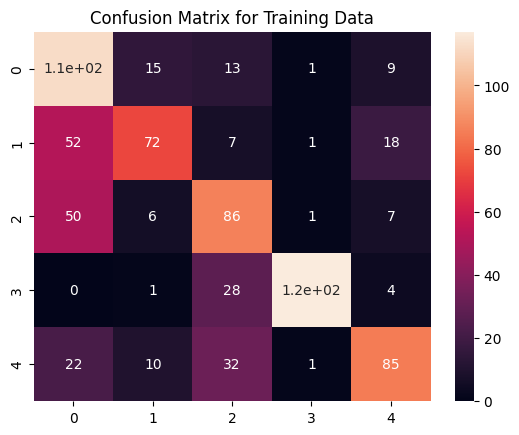

Accuracy: 0.572 %


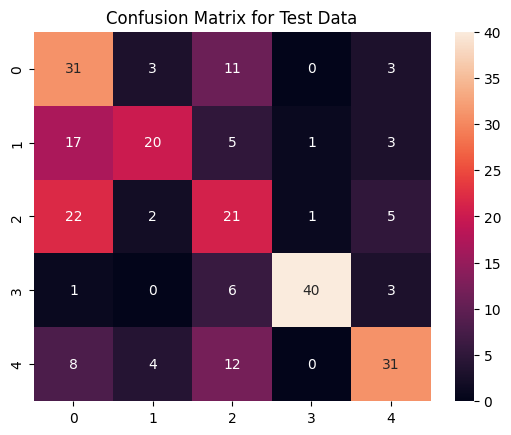

In [ ]:
cf_train = conf_matrix(model, X_train, y_train)
sns.heatmap(cf_train, annot=True)
plt.title('Confusion Matrix for Training Data')
plt.show()

cf_test = conf_matrix(model, X_test, y_test)
plt.title('Confusion Matrix for Test Data')
sns.heatmap(cf_test, annot=True)
plt.show()

## (b) DFNN using stacked autoencoder

In [ ]:
# ae1 = AANN(36, 30, 24)
# ae2 = AANN(24, 20, 16)
# ae3 = AANN(16, 12, 8)
# ae_list = [ae1, ae2, ae3]

In [ ]:
learning_rate = 0.01
threshold = 1e-6

### Training AANN1

In [ ]:
X_train_unlab_tensor = torch.from_numpy(X_train_unlab.values).float()
train_loader_unlab = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_unlab_tensor, X_train_unlab_tensor),
                                            batch_size=64, shuffle=True)

In [ ]:
ae1 = AANN(36, 30, 24)
ae1.to(torch.float32)
loss_func = nn.MSELoss()
avg_error_dict, _ = train(ae1, train_loader_unlab, loss_func)

EPOCH: 1 BATCH: 0 LOSS: 0.05705215409398079
EPOCH: 1 BATCH: 1 LOSS: 0.030494242906570435
EPOCH: 1 BATCH: 2 LOSS: 0.01668781042098999
EPOCH: 1 BATCH: 3 LOSS: 0.014164234511554241
EPOCH: 1 BATCH: 4 LOSS: 0.011643651872873306
EPOCH: 1 BATCH: 5 LOSS: 0.011183558031916618
EPOCH: 1 BATCH: 6 LOSS: 0.009662561118602753
EPOCH: 1 BATCH: 7 LOSS: 0.010183896869421005
EPOCH: 1 BATCH: 8 LOSS: 0.009424015879631042
EPOCH: 1 BATCH: 9 LOSS: 0.009185080416500568
EPOCH: 1 BATCH: 10 LOSS: 0.009234292432665825
EPOCH: 1 BATCH: 11 LOSS: 0.008012301288545132
EPOCH: 1 BATCH: 12 LOSS: 0.007961587980389595
EPOCH: 1 BATCH: 13 LOSS: 0.007840831764042377
EPOCH: 1 BATCH: 14 LOSS: 0.007485785521566868
EPOCH: 1 BATCH: 15 LOSS: 0.007186535280197859
EPOCH: 1 BATCH: 16 LOSS: 0.00672374852001667
EPOCH: 1 BATCH: 17 LOSS: 0.00680748512968421
EPOCH: 1 BATCH: 18 LOSS: 0.0068053859286010265
EPOCH: 1 BATCH: 19 LOSS: 0.006358817685395479
EPOCH: 1 BATCH: 20 LOSS: 0.005732398480176926
EPOCH: 1 BATCH: 21 LOSS: 0.006281507667154074
E

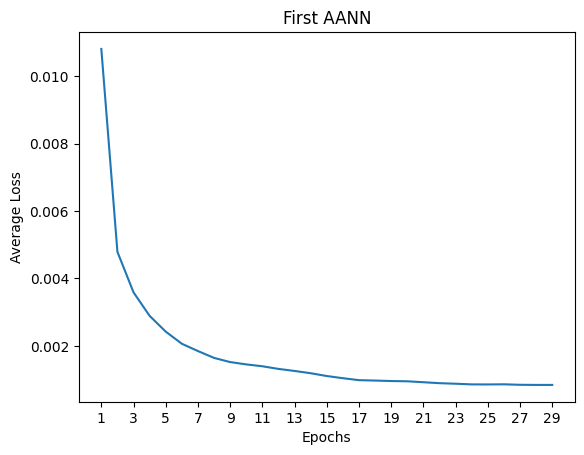

In [ ]:
plt.plot(list(map(str, list(avg_error_dict.keys()))), list(avg_error_dict.values()), label='Average training loss')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('First AANN')
plt.xticks(list(map(str, list(avg_error_dict.keys())))[::2])
plt.show()

### Training AANN2

In [ ]:
# Bottleneck output
Z1_train = []
for i in range(len(X_train_unlab_tensor)):
  with torch.no_grad():
    z1 = ae1.bottle_neck(X_train_unlab_tensor[i])
    Z1_train.append(z1)
Z1_train_tensor = torch.stack(Z1_train)
Z1_train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(Z1_train_tensor, Z1_train_tensor),
                                            batch_size=64, shuffle=True)

In [ ]:
ae2 = AANN(24, 20, 16)
ae2.to(torch.float32)
loss_func = nn.MSELoss()
avg_error_dict, _ = train(ae2, Z1_train_loader, loss_func)

EPOCH: 1 BATCH: 0 LOSS: 0.037939589470624924
EPOCH: 1 BATCH: 1 LOSS: 0.0281301811337471
EPOCH: 1 BATCH: 2 LOSS: 0.02149146981537342
EPOCH: 1 BATCH: 3 LOSS: 0.017532045021653175
EPOCH: 1 BATCH: 4 LOSS: 0.013668582774698734
EPOCH: 1 BATCH: 5 LOSS: 0.013575778342783451
EPOCH: 1 BATCH: 6 LOSS: 0.013060669414699078
EPOCH: 1 BATCH: 7 LOSS: 0.014111212454736233
EPOCH: 1 BATCH: 8 LOSS: 0.0113553861156106
EPOCH: 1 BATCH: 9 LOSS: 0.010290847159922123
EPOCH: 1 BATCH: 10 LOSS: 0.011688832193613052
EPOCH: 1 BATCH: 11 LOSS: 0.011723105795681477
EPOCH: 1 BATCH: 12 LOSS: 0.010926462709903717
EPOCH: 1 BATCH: 13 LOSS: 0.01018800213932991
EPOCH: 1 BATCH: 14 LOSS: 0.010028956457972527
EPOCH: 1 BATCH: 15 LOSS: 0.009921679273247719
EPOCH: 1 BATCH: 16 LOSS: 0.01011564303189516
EPOCH: 1 BATCH: 17 LOSS: 0.008634335361421108
EPOCH: 1 BATCH: 18 LOSS: 0.008696681819856167
EPOCH: 1 BATCH: 19 LOSS: 0.008362705819308758
EPOCH: 1 BATCH: 20 LOSS: 0.008663748390972614
EPOCH: 1 BATCH: 21 LOSS: 0.008327716961503029
EPOCH

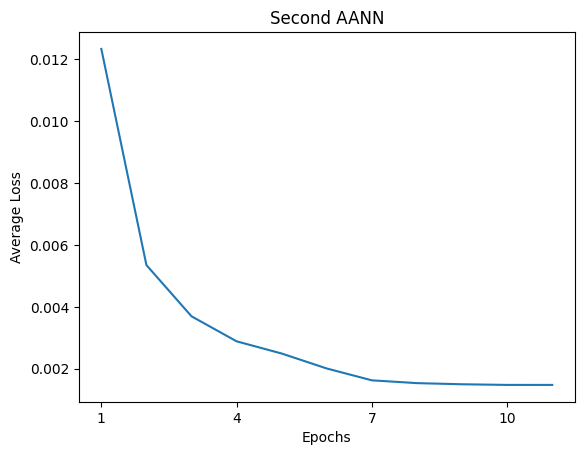

In [ ]:
plt.plot(list(map(str, list(avg_error_dict.keys()))), list(avg_error_dict.values()), label='Average training loss')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Second AANN')
plt.xticks(list(map(str, list(avg_error_dict.keys())))[::3])
plt.show()

### Training AANN3

In [ ]:
threshold = 1e-5
# Bottleneck output
Z2_train = []
for i in range(len(Z1_train_tensor)):
  with torch.no_grad():
    z2 = ae2.bottle_neck(Z1_train_tensor[i])
    Z2_train.append(z2)
Z2_train_tensor = torch.stack(Z2_train)
Z2_train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(Z2_train_tensor, Z2_train_tensor),
                                            batch_size=64, shuffle=True)

In [ ]:
ae3 = AANN(16, 12, 8)
ae3.to(torch.float32)
loss_func = nn.MSELoss()
avg_error_dict, _ = train(ae3, Z2_train_loader, loss_func)

EPOCH: 1 BATCH: 0 LOSS: 0.04978112131357193
EPOCH: 1 BATCH: 1 LOSS: 0.03785597160458565
EPOCH: 1 BATCH: 2 LOSS: 0.0352897047996521
EPOCH: 1 BATCH: 3 LOSS: 0.03285626694560051
EPOCH: 1 BATCH: 4 LOSS: 0.030667921528220177
EPOCH: 1 BATCH: 5 LOSS: 0.030033797025680542
EPOCH: 1 BATCH: 6 LOSS: 0.029978029429912567
EPOCH: 1 BATCH: 7 LOSS: 0.027604348957538605
EPOCH: 1 BATCH: 8 LOSS: 0.03107728809118271
EPOCH: 1 BATCH: 9 LOSS: 0.026292696595191956
EPOCH: 1 BATCH: 10 LOSS: 0.028167055919766426
EPOCH: 1 BATCH: 11 LOSS: 0.02626780979335308
EPOCH: 1 BATCH: 12 LOSS: 0.02590588852763176
EPOCH: 1 BATCH: 13 LOSS: 0.02406231500208378
EPOCH: 1 BATCH: 14 LOSS: 0.02241094782948494
EPOCH: 1 BATCH: 15 LOSS: 0.0251214150339365
EPOCH: 1 BATCH: 16 LOSS: 0.022407736629247665
EPOCH: 1 BATCH: 17 LOSS: 0.024698257446289062
EPOCH: 1 BATCH: 18 LOSS: 0.02225467935204506
EPOCH: 1 BATCH: 19 LOSS: 0.022262463346123695
EPOCH: 1 BATCH: 20 LOSS: 0.021249212324619293
EPOCH: 1 BATCH: 21 LOSS: 0.022446228191256523
EPOCH: 1 BA

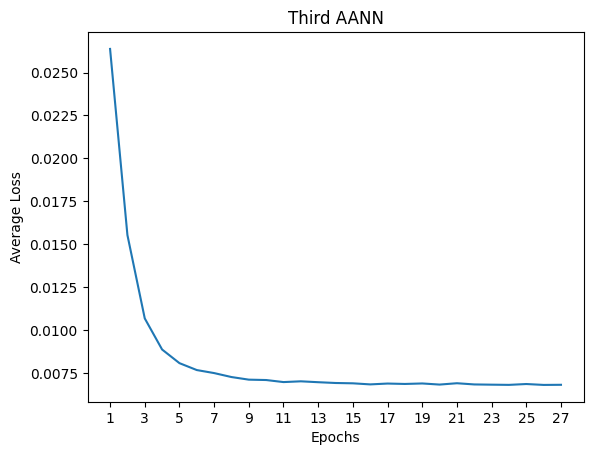

In [ ]:
plt.plot(list(map(str, list(avg_error_dict.keys()))), list(avg_error_dict.values()), label='Average training loss')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Third AANN')
plt.xticks(list(map(str, list(avg_error_dict.keys())))[::2])
plt.show()

### Finetuning the stacked pre-trained autoencoders

In [ ]:
learning_rate = 0.01
threshold = 1e-3
cae1 = ae1
cae2 = ae2
cae3 = ae3

In [ ]:
model = StackedAutoencoder(ae1, ae2, ae3)
model.to(torch.float32)
loss_func = nn.CrossEntropyLoss()
avg_error_dict, validation_loss = train(model, train_loader, loss_func, (X_valid_tensor, y_valid_tensor))

EPOCH: 1 BATCH: 0 LOSS: 1.6624407768249512
EPOCH: 1 BATCH: 1 LOSS: 1.53788423538208
EPOCH: 1 BATCH: 2 LOSS: 1.5417560338974
EPOCH: 1 BATCH: 3 LOSS: 1.5723739862442017
EPOCH: 1 BATCH: 4 LOSS: 1.62431001663208
EPOCH: 1 BATCH: 5 LOSS: 1.537086844444275
EPOCH: 1 BATCH: 6 LOSS: 1.414870023727417
EPOCH: 1 BATCH: 7 LOSS: 1.4852460622787476
EPOCH: 1 BATCH: 8 LOSS: 1.442383885383606
EPOCH: 1 BATCH: 9 LOSS: 1.349908471107483
EPOCH: 1 BATCH: 10 LOSS: 1.3082562685012817
EPOCH: 1 BATCH: 11 LOSS: 1.245427131652832
EPOCH: 1 BATCH: 12 LOSS: 1.2498596906661987
EPOCH: 1 BATCH: 13 LOSS: 1.385506510734558
EPOCH: 1 BATCH: 14 LOSS: 1.3997210264205933
EPOCH: 1 BATCH: 15 LOSS: 1.3305679559707642
EPOCH: 1 BATCH: 16 LOSS: 1.1361651420593262
EPOCH: 1 BATCH: 17 LOSS: 1.136626124382019
EPOCH: 1 BATCH: 18 LOSS: 1.1939460039138794
EPOCH: 1 BATCH: 19 LOSS: 1.2414852380752563
EPOCH: 1 BATCH: 20 LOSS: 1.3509689569473267
EPOCH: 1 BATCH: 21 LOSS: 1.4361785650253296
EPOCH: 1 BATCH: 22 LOSS: 1.2072291374206543
EPOCH: 1 BAT

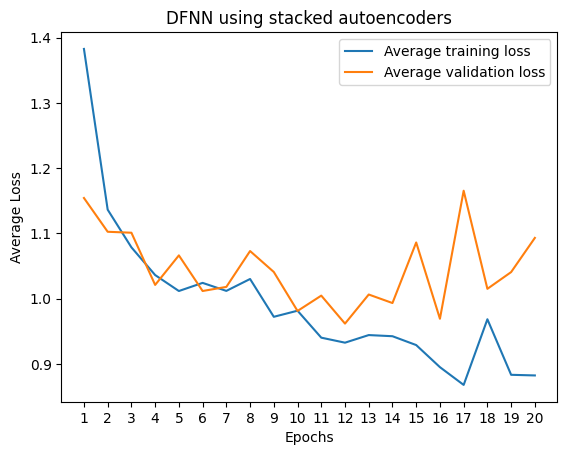

In [ ]:
plt.plot(list(map(str, list(avg_error_dict.keys()))), list(avg_error_dict.values()), label='Average training loss')
plt.plot(list(map(str, list(validation_loss.keys()))), list(validation_loss.values()), label='Average validation loss')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('DFNN using stacked autoencoders')
plt.xticks(list(map(str, list(avg_error_dict.keys())))[::1])
plt.legend()
plt.show()

Accuracy: 0.6386666666666667 %


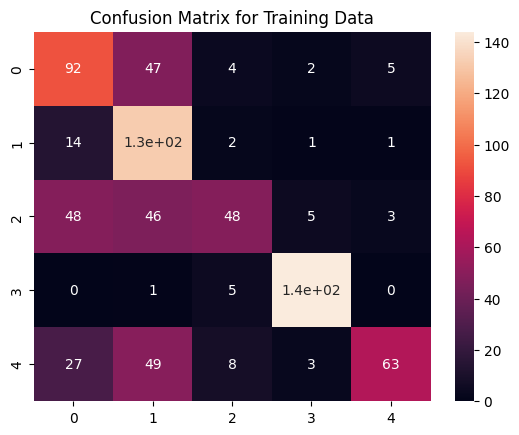

Accuracy: 0.564 %


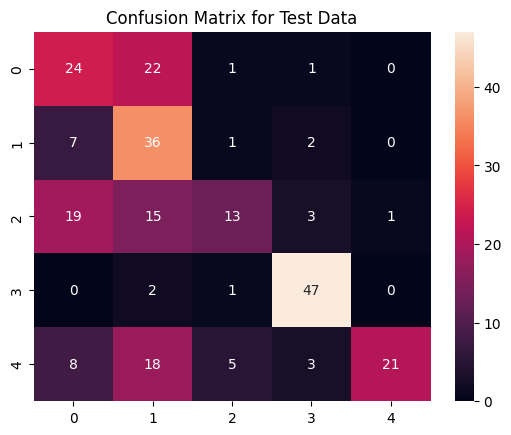

In [ ]:
cf_train = conf_matrix(model, X_train, y_train)
sns.heatmap(cf_train, annot=True)
plt.title('Confusion Matrix for Training Data')
plt.show()

cf_test = conf_matrix(model, X_test, y_test)
plt.title('Confusion Matrix for Test Data')
sns.heatmap(cf_test, annot=True)
plt.show()

In [ ]:
print("First Autoencoder")
for layer in ae1.children():
  print(layer)

print("Second Autoencoder")
for layer in ae2.children():
  print(layer)

print("Third Autoencoder")
for layer in ae3.children():
  print(layer)

First Autoencoder
Linear(in_features=36, out_features=30, bias=True)
Linear(in_features=30, out_features=24, bias=True)
Linear(in_features=24, out_features=30, bias=True)
Linear(in_features=30, out_features=36, bias=True)
Second Autoencoder
Linear(in_features=24, out_features=20, bias=True)
Linear(in_features=20, out_features=16, bias=True)
Linear(in_features=16, out_features=20, bias=True)
Linear(in_features=20, out_features=24, bias=True)
Third Autoencoder
Linear(in_features=16, out_features=12, bias=True)
Linear(in_features=12, out_features=8, bias=True)
Linear(in_features=8, out_features=12, bias=True)
Linear(in_features=12, out_features=16, bias=True)


In [ ]:
model = StackedAutoencoder(ae1, ae2, ae3)


In [ ]:
for layer in model.children():
  print(layer)

AANN(
  (hl1): Linear(in_features=36, out_features=30, bias=True)
  (hl2): Linear(in_features=30, out_features=24, bias=True)
  (hl3): Linear(in_features=24, out_features=30, bias=True)
  (ol): Linear(in_features=30, out_features=36, bias=True)
)
AANN(
  (hl1): Linear(in_features=24, out_features=20, bias=True)
  (hl2): Linear(in_features=20, out_features=16, bias=True)
  (hl3): Linear(in_features=16, out_features=20, bias=True)
  (ol): Linear(in_features=20, out_features=24, bias=True)
)
AANN(
  (hl1): Linear(in_features=16, out_features=12, bias=True)
  (hl2): Linear(in_features=12, out_features=8, bias=True)
  (hl3): Linear(in_features=8, out_features=12, bias=True)
  (ol): Linear(in_features=12, out_features=16, bias=True)
)
Linear(in_features=8, out_features=5, bias=True)
